In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from collections import defaultdict
from queue import PriorityQueue, Queue
import math
from matplotlib import pyplot as plt

In [4]:
class Point(object):
    def __init__(self, x, y, polygon_id=-1):
        self.x = x
        self.y = y
        self.polygon_id = polygon_id
        self.g = 0
        self.pre = None

    def rel(self, other, line):
        return line.d(self) * line.d(other) >= 0

    def can_see(self, other, line):
        l1 = self.line_to(line.p1)
        l2 = self.line_to(line.p2)
        d3 = line.d(self) * line.d(other) < 0
        d1 = other.rel(line.p2, l1)
        d2 = other.rel(line.p1, l2)
        return not(d1 and d2 and d3)

    def line_to(self, other):
        return Edge(self, other)

    def heuristic(self, other):
        return euclid_distance(self, other)

    def __eq__(self, point):
        return point and self.x == point.x and self.y == point.y

    def __ne__(self, point):
        return not self.__eq__(point)

    def __lt__(self, point):
        return hash(self) < hash(point)

    def __str__(self):
        return "(%d, %d)" % (self.x, self.y)

    def __hash__(self):
        return self.x.__hash__() ^ self.y.__hash__()

    def __repr__(self):
        return "(%d, %d)" % (self.x, self.y)


class Edge(object):
    def __init__(self, point1, point2):
        self.p1 = point1
        self.p2 = point2

    def get_adjacent(self, point):
        if point == self.p1:
            return self.p2
        if point == self.p2:
            return self.p1

    def d(self, point):
        vect_a = Point(self.p2.x - self.p1.x, self.p2.y - self.p1.y)
        vect_n = Point(-vect_a.y, vect_a.x)
        return vect_n.x * (point.x - self.p1.x) + vect_n.y * (point.y - self.p1.y)

    def __str__(self):
        return "({}, {})".format(self.p1, self.p2)

    def __contains__(self, point):
        return self.p1 == point or self.p2 == point

    def __hash__(self):
        return self.p1.__hash__() ^ self.p2.__hash__()

    def __repr__(self):
        return "Edge({!r}, {!r})".format(self.p1, self.p2)


class Graph:
    def __init__(self, polygons):
        self.graph = defaultdict(set)
        self.edges = set()
        self.polygons = defaultdict(set)
        pid = 0
        for polygon in polygons:
            if len(polygon) == 2:
                polygon.pop()
            if polygon[0] == polygon[-1]:
                self.add_point(polygon[0])
            else:
                for i, point in enumerate(polygon):
                    neighbor_point = polygon[(i + 1) % len(polygon)]
                    edge = Edge(point, neighbor_point)
                    if len(polygon) > 2:
                        point.polygon_id = pid
                        neighbor_point.polygon_id = pid
                        self.polygons[pid].add(edge)
                    self.add_edge(edge)
                if len(polygon) > 2:
                    pid += 1

    def get_adjacent_points(self, point):
        return list(filter(None.__ne__, [edge.get_adjacent(point) for edge in self.edges]))

    def can_see(self, start):
        see_list = list()
        cant_see_list = list()

        for polygon in self.polygons:
            for edge in self.polygons[polygon]:
                for point in self.get_points():
                    if start == point:
                        cant_see_list.append(point)
                    if start in self.get_polygon_points(polygon):
                        for poly_point in self.get_polygon_points(polygon):
                            if poly_point not in self.get_adjacent_points(start):
                                cant_see_list.append(poly_point)
                    if point not in cant_see_list:
                        if start.can_see(point, edge):
                            if point not in see_list:
                                see_list.append(point)
                        elif point in see_list:
                            see_list.remove(point)
                            cant_see_list.append(point)
                        else:
                            cant_see_list.append(point)

        return see_list

    def can_go(self, start):
        can_go = set()
        polygons = self.get_polygons()
        can_see = self.can_see(start)
        for point in can_see:
            if point.polygon_id != start.polygon_id:
                can_go.add(point)
            else:
                edge = Edge(start, point)
                if edge in polygons[start.polygon_id]:
                    can_go.add(point)
        return can_go

    def get_points(self):
        return list(self.graph)

    def get_edges(self):
        return self.edges

    def get_polygons(self):
        return self.polygons

    def get_polygon_points(self, index):
        point_set = set()
        for edge in self.polygons[index]:
            point_set.add(edge.p1)
            point_set.add(edge.p2)
        return point_set

    def add_point(self, point):
        self.graph[point].add(point)

    def add_edge(self, edge):
        self.graph[edge.p1].add(edge)
        self.graph[edge.p2].add(edge)
        self.edges.add(edge)

    def __contains__(self, item):
        if isinstance(item, Point):
            return item in self.graph
        if isinstance(item, Edge):
            return item in self.edges
        return False

    def __getitem__(self, point):
        if point in self.graph:
            return self.graph[point]
        return set()

    def __str__(self):
        res = ""
        for point in self.graph:
            res += '\n' + str(point) + ' : '
            for edge in self.graph[point]:
                res += str(edge)
        return res

    def __repr__(self):
        return self.__str__()

    def h(self, point):
        heuristic = getattr(self, 'heuristic', None)
        if heuristic:
            return heuristic[point]
        else:
            return -1


def euclid_distance(point1, point2):
    # It must be the power of 2, not 3
    # return round(float(math.sqrt((point2.x - point1.x) ** 2 + (point2.y - point1.y) ** 2)), 3)
    return round(float(math.sqrt((point2.x - point1.x) ** 2 + (point2.y - point1.y) ** 2)), 2)


def search(graph, start, goal, func):
    closed = set()
    queue = PriorityQueue()
    queue.put((0 + func(graph, start), start))
    if start not in closed:
        closed.add(start)
    while not queue.empty():
        cost, node = queue.get()
        if node == goal:
            return node
        for i in graph.can_go(node):
            new_cost = node.g + euclid_distance(node, i)
            if i not in closed or new_cost < i.g:
                closed.add(i)
                i.g = new_cost
                i.pre = node
                new_cost = func(graph, i)
                queue.put((new_cost, i))

    return node


a_star = lambda graph, i: i.g + graph.h(i)
greedy = lambda graph, i: graph.h(i)


In [5]:
def bfs(graph, start, goal):
    closed = set()
    queue = Queue()
    queue.put(start)
    if start not in closed:
        closed.add(start)
    while not queue.empty():
        node = queue.get()
        if node == goal:
            return node
        for i in graph.can_go(node):
            if i not in closed:
                closed.add(i)
                i.pre = node
                queue.put(i)
    return node

In [6]:
def dfs(graph, start, goal):
    closed = set()
    stack = list()
    stack.append(start)
    if start not in closed:
        closed.add(start)
    while stack is not None:
        node = stack.pop()
        if node == goal:
            return node
        for i in graph.can_go(node):
            if i not in closed:
                closed.add(i)
                i.pre = node
                stack.append(i)
    return node

In [7]:
def ucs(graph, start, goal):
    closed = set()
    queue = PriorityQueue()
    queue.put((0, start))
    if start not in closed:
        closed.add(start)
    while not queue.empty():
        cost, node = queue.get()
        if node == goal:
            return node
        for i in graph.can_go(node):
            new_cost = node.g + i.g
            if i not in closed or new_cost < i.g:
                closed.add(i)
                i.g = new_cost
                i.pre = node
                queue.put((new_cost, i))
    return node


<ipython-input-4-1add4d0ace87>:98: DeprecationWarning: NotImplemented should not be used in a boolean context
  return list(filter(None.__ne__, [edge.get_adjacent(point) for edge in self.edges]))


A* Path:
[[(2, 4), -1], [(4, 7), 0], [(16, 9), 2], [(21, 12), 4], [(25, 11), 5], [(32, 10), 7], [(35, 9), 6], [(38, 21), -1]]


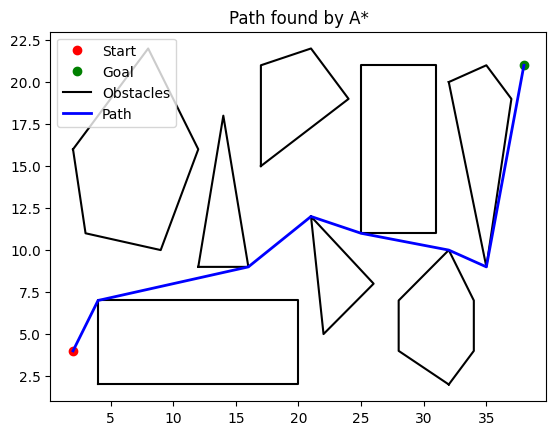

GBFS Path:
[[(2, 4), -1], [(3, 11), 1], [(20, 7), 0], [(21, 12), 4], [(25, 11), 5], [(32, 10), 7], [(31, 21), 5], [(35, 21), 6], [(38, 21), -1]]


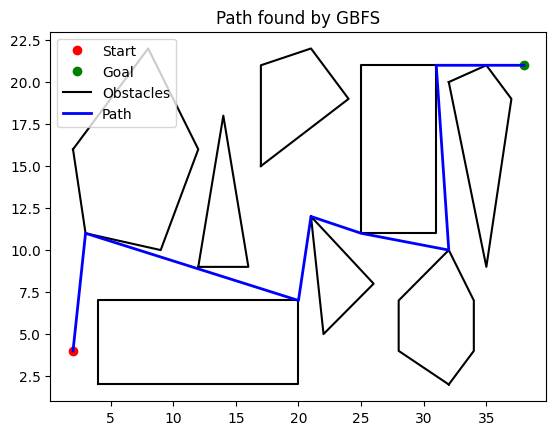

BFS Path:
[[(2, 4), -1], [(3, 11), 1], [(20, 7), 0], [(22, 5), 4], [(32, 10), 7], [(35, 9), 6], [(38, 21), -1]]


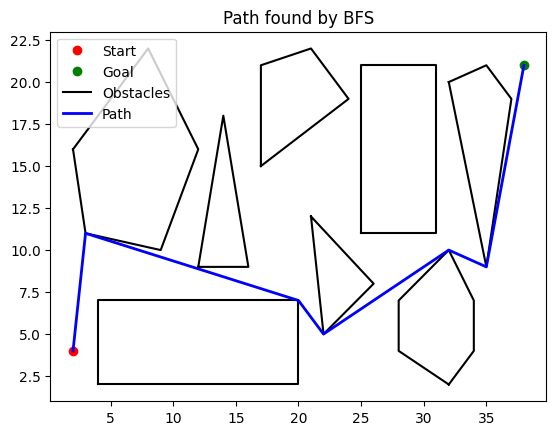

DFS Path:
[[(2, 4), -1], [(4, 7), 0], [(16, 9), 2], [(17, 15), 3], [(14, 18), 2], [(8, 22), 1], [(21, 22), 3], [(38, 21), -1]]


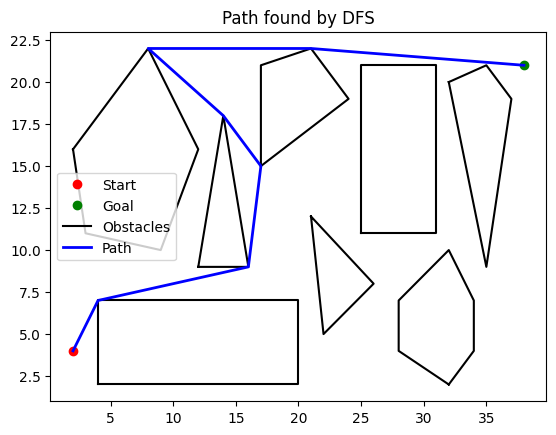

UCS Path:
[[(2, 4), -1], [(4, 7), 0], [(12, 9), 2], [(20, 7), 0], [(22, 5), 4], [(31, 11), 5], [(26, 8), 4], [(25, 11), 5], [(24, 19), 3], [(25, 21), 5], [(21, 22), 3], [(38, 21), -1]]


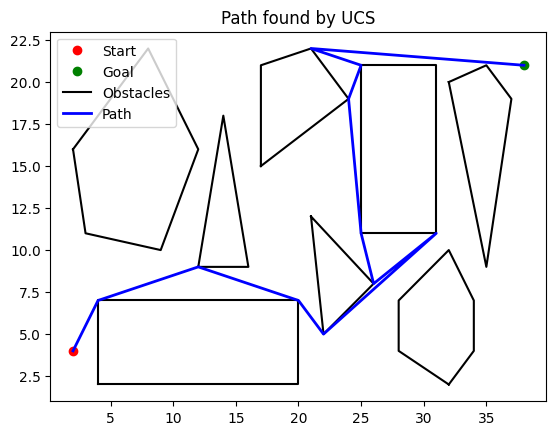

In [27]:
def main():
    n_polygon = 0
    poly_list = list(list())
    x = list()
    y = list()

    # Đọc dữ liệu từ file
    path = '/content/drive/My Drive/AI Tuan 4/Input.txt'
    with open(path, 'r') as f:
        line = f.readline()
        line = line.strip()
        line = line.split()
        line = list(map(int, line))
        n_polygon = line[0]
        start = Point(line[1], line[2])
        goal = Point(line[3], line[4])
        poly_list.append([start])
        for line in f:
            point_list = list()
            line = line.split()
            n_vertex = int(line[0])
            for j in range(0, 2*n_vertex, 2):
                point_list.append(Point(int(line[j + 1]), int(line[j + 2])))
            poly_list.append(point_list[:])
        poly_list.append([goal])

    # Tạo graph
    graph = Graph(poly_list)
    graph.add_point(start)
    graph.heuristic = {point: point.heuristic(goal) for point in graph.get_points()}

    # Các thuật toán
    algorithms = {
        "A*": a_star,
        "GBFS": greedy,
        "BFS": bfs,
        "DFS": dfs,
        "UCS": ucs
    }

    # Lặp qua từng thuật toán
    for name, func in algorithms.items():
        # Reset g và pre cho các điểm
        for point in graph.get_points():
            point.g = 0
            point.pre = None

        # Chạy thuật toán
        if name in ["BFS", "DFS", "UCS"]:
            path = func(graph, start, goal)
        else:
            path = search(graph, start, goal, func)

        # Lưu kết quả đường đi
        result = list()
        while path:
            result.append(path)
            path = path.pre
        result.reverse()

        # In ra kết quả
        print(f"{name} Path:")
        print([[point, point.polygon_id] for point in result])

        # Vẽ đường đi
        plt.figure()
        plt.title(f"Path found by {name}")
        plt.plot([start.x], [start.y], 'ro', label="Start")
        plt.plot([goal.x], [goal.y], 'go', label="Goal")

        for i in range(1, len(poly_list) - 1):
            coord = list()
            for point in poly_list[i]:
                coord.append([point.x, point.y])
            coord.append(coord[0])
            xs, ys = zip(*coord)  # Create lists of x and y values
            plt.plot(xs, ys, 'k-', label="Obstacles" if i == 1 else "")  # Chỉ ghi nhãn lần đầu

        x = [point.x for point in result]
        y = [point.y for point in result]
        plt.plot(x, y, 'b', linewidth=2.0, label="Path")
        plt.legend()
        plt.show()


if __name__ == "__main__":
    main()


<ipython-input-4-1add4d0ace87>:98: DeprecationWarning: NotImplemented should not be used in a boolean context
  return list(filter(None.__ne__, [edge.get_adjacent(point) for edge in self.edges]))


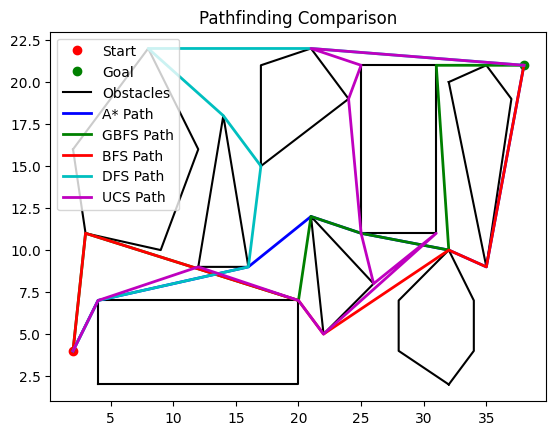

In [30]:
def main():
    n_polygon = 0
    poly_list = list(list())

    # Đọc dữ liệu từ file
    path = '/content/drive/My Drive/AI Tuan 4/Input.txt'
    with open(path, 'r') as f:
        line = f.readline()
        line = line.strip()
        line = line.split()
        line = list(map(int, line))
        n_polygon = line[0]
        start = Point(line[1], line[2])
        goal = Point(line[3], line[4])
        poly_list.append([start])
        for line in f:
            point_list = list()
            line = line.split()
            n_vertex = int(line[0])
            for j in range(0, 2*n_vertex, 2):
                point_list.append(Point(int(line[j + 1]), int(line[j + 2])))
            poly_list.append(point_list[:])
        poly_list.append([goal])

    # Tạo graph
    graph = Graph(poly_list)
    graph.add_point(start)
    graph.heuristic = {point: point.heuristic(goal) for point in graph.get_points()}

    # Các thuật toán
    algorithms = {
        "A*": a_star,
        "GBFS": greedy,
        "BFS": bfs,
        "DFS": dfs,
        "UCS": ucs
    }

    # Tạo màu sắc cho từng thuật toán
    colors = {
        "A*": 'b',       # Blue
        "GBFS": 'g',     # Green
        "BFS": 'r',      # Red
        "DFS": 'c',      # Cyan
        "UCS": 'm'       # Magenta
    }

    # Khởi tạo biểu đồ
    plt.figure()
    plt.title("Pathfinding Comparison")
    plt.plot([start.x], [start.y], 'ro', label="Start")  # Start point
    plt.plot([goal.x], [goal.y], 'go', label="Goal")    # Goal point

    # Vẽ các đa giác
    for i in range(1, len(poly_list) - 1):
        coord = list()
        for point in poly_list[i]:
            coord.append([point.x, point.y])
        coord.append(coord[0])
        xs, ys = zip(*coord)
        plt.plot(xs, ys, 'k-', label="Obstacles" if i == 1 else "")  # Chỉ ghi nhãn 1 lần

    # Chạy và vẽ kết quả từ từng thuật toán
    for name, func in algorithms.items():
        # Reset g và pre cho các điểm
        for point in graph.get_points():
            point.g = 0
            point.pre = None

        # Chạy thuật toán
        if name in ["BFS", "DFS", "UCS"]:
            path = func(graph, start, goal)
        else:
            path = search(graph, start, goal, func)

        # Lưu kết quả đường đi
        result = list()
        while path:
            result.append(path)
            path = path.pre
        result.reverse()

        # Vẽ đường đi
        x = [point.x for point in result]
        y = [point.y for point in result]
        plt.plot(x, y, colors[name], linewidth=2.0, label=f"{name} Path")

    # Hiển thị chú thích và đồ thị
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()
